# Fantasy Football Player Unsupervised Clustering 

>Fantasy sports is big business! As an estimated **7-billion dollar** industry, with another estimated 59 million fantasy sports participants in the United States and Canada, fantasy sports isn't going anywhere, anytime soon. With fantasy drafts, trade deadlines, and salary caps, fantasy sports puts everyday, average Joes and Janes in the front office, where they can flex their sports knowledge  about real playeres competing in real contests against friend, family and foe alike. In fact, fantasy sports is so popular, that an entire industry of its own came into being with the sole purpose of servicing fantasy enthusiasts, providing them with statistics, gossip, insights and most of all, predictions! Chief among fantasy sports is none other than Fantasy Football...and I don't mean *soccer*.

### Why?
In fantasy sports, every player is trying to find that edge! Oftentimes, that edge comes from being able to identify when low-priced, low-owned (under the radar) NFL players are primed to have an explosive game. The following analysis aims to classify real-life, NFL football players at the quarterback, runningback and wide receiver positions, based on their fantasy scoring abilities, which should be noted, is *not* the same thing as actual scoring in NFL Football. The intended utility of a player clustering algorithm would be to allow a fantasy football enthusiast to classify similarly skilled players into tiers and then to leverage the lower priced players within a desired tier to one's own advantage, hopefully saving money by rostering that player without sacrificing too much scoring potential.

### The Scoring
We'll be using the Draftkings scoring citeria for this analysis. DraftKings is a leading American daily-fantasy sports contest and sports betting company where fantasy enthusiasts can compete for real money. Their fantasy contests employ a 'salary cap', preventing each fantasy enthusiast from acquiring all the top projected talent. They also use a Player Pool wherein different players are priced according to their perceived skills and matchups. It is these built-in limitations that tier clustering hopes to circumvent. Draftkings has an unsual scoring system where they award 1 point for every reception (aka Points-per-reception, or PPR), 3-point bonuses for every 100 yard rushing or receiving performace as well as 300 yard passing performances. The complete offensive scoring breakdown is as follows:

+ Passing TD: +4 Pts

+ 25 Passing Yards: +1 Pt (+0.04 Pts/ Yards)

+ 300+ Yard Passing Game: +3 Pts

+ Interception: -1 Pt

+ Rushing TD: +6 Pts

+ 10 Rushing Yards: +1 Pt (+0.1 Pts/Yard)

+ 100+ Yard Rushing Game: +3 Pts

+ Receiving TD: +6 Pts

+ 10 Receiving Yards: +1 Pt (+0.1 Pts/Yard)

+ 100+ Receiving Yard Game: +3 Pts

+ Reception: +1 Pt

+ Punt/Kickoff/FG Return for TD: +6 Pts

+ Fumble Lost: -1 Pt

+ 2 Pt Conversion (Pass, Run, or Catch): +2 Pts

+ Offensive Fumble Recovery TD: +6 Pts

In [1207]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

In [1208]:
nfl = pd.read_html('https://www.pro-football-reference.com/years/2019/fantasy.htm')
nfl = nfl[0]
nfl.head()

Unnamed: 0_level_0     Unnamed: 1_level_0 Unnamed: 2_level_0  \
                  Rk                 Player                 Tm   
0  1                  Christian McCaffrey*+  CAR                 
1  2                  Lamar Jackson*+        BAL                 
2  3                  Derrick Henry*         TEN                 
3  4                  Aaron Jones            GNB                 
4  5                  Ezekiel Elliott*       DAL                 

  Unnamed: 3_level_0 Unnamed: 4_level_0 Games     Passing             ...  \
             FantPos                Age     G  GS     Cmp  Att   Yds  ...   
0  RB                 23                 16    16  0       2    0     ...   
1  QB                 22                 15    15  265     401  3127  ...   
2  RB                 25                 15    15  0       0    0     ...   
3  RB                 25                 16    16  0       0    0     ...   
4  RB                 24                 16    16  0       0    0     ...   

  Scoring           Fantasy                                           
       TD  2PM  2PP  FantPt    PPR   DKPt   FDPt  VBD PosRank OvRank  
0  19      1    NaN  355     471.2  477.2  413.2  215  1       1      
1  7       NaN  NaN  416     415.7  429.7  421.7  152  1       2      
2  18      NaN  NaN  277     294.6  303.6  285.6  136  2       3      
3  19      NaN  NaN  266     314.8  322.8  290.3  125  3       4      
4  14      NaN  NaN  258     311.7  319.7  284.7  117  4       5      

[5 rows x 33 columns]

In [1209]:
# Formatting the column names
nfl_list = []
for i in range(len(nfl.columns)):
     nfl_list.append(nfl.columns[i][0] + '_' + nfl.columns[i][1])
nfl.columns = nfl_list

nfl['player'] = nfl['Unnamed: 1_level_0_Player']
nfl['position'] = nfl['Unnamed: 3_level_0_FantPos']
nfl.columns = nfl.columns.str.replace('Passing', 'pass').str.replace('Rushing','rush').str.replace('Fantasy_','')
nfl.columns = nfl.columns.str.replace('Games_', '').str.replace('Receiving','rec').str.replace('Rec','recs').str.replace('Fumbles_','')
nfl.columns = nfl.columns.str.replace('rec_recs', 'receptions').str.replace('FL','fumbles_lost')

nfl = nfl.drop(['Unnamed: 0_level_0_Rk', 'Unnamed: 1_level_0_Player', 'Unnamed: 2_level_0_Tm', 
         'Unnamed: 3_level_0_FantPos', 'Unnamed: 4_level_0_Age','VBD','PosRank','OvRank',
         'Scoring_2PM','Scoring_2PP'], axis=1)

In [1210]:
''' RUN THIS CELL ONLY ONCE'''

# Lowercase column names
nfl.columns = nfl.columns.str.lower()
nfl.player = nfl.player.str.strip('+').str.strip('*')

# Rearranging column order to ['player', 'position', ...]
cols = nfl.columns.tolist()
cols = cols[-2:] + cols[:-2]
nfl = nfl[cols]
nfl.head(2)

player position   g  gs pass_cmp pass_att pass_yds pass_td  \
0  Christian McCaffrey  RB       16  16  0        2        0        0        
1  Lamar Jackson        QB       15  15  265      401      3127     36       

  pass_int rush_att  ... rec_yds rec_y/r rec_td fmb fumbles_lost scoring_td  \
0  0        287      ...  1005    8.66    4      1   0            19          
1  6        176      ...  0       NaN     0      9   2            7           

  fantpt    ppr   dkpt   fdpt  
0  355    471.2  477.2  413.2  
1  416    415.7  429.7  421.7  

[2 rows x 25 columns]

In [1211]:
nfl.describe()

player position    g   gs pass_cmp pass_att pass_yds pass_td pass_int  \
count   640     577      640  640  640      640      640      640     640       
unique  620     5        18   18   61       64       79       27      20        
top     Player  WR       16   0    0        0        0        0       0         
freq    20      217      164  174  536      527      536      564     560       

       rush_att  ... rec_yds rec_y/r rec_td  fmb fumbles_lost scoring_td  \
count   640      ...  640     494     640    640  640          640         
unique  112      ...  317     330     13     18   9            18          
top     0        ...  0       Y/R     0      0    0            0           
freq    296      ...  146     20      355    399  453          279         

       fantpt  ppr  dkpt  fdpt  
count   564    579  579   579   
unique  185    456  469   433   
top     1      PPR  DKPt  FDPt  
freq    38     20   20    20    

[4 rows x 25 columns]

> We need to explore what the player name 'Player' is all about.

In [1212]:
nfl.loc[nfl.player == 'Player'].head()

player position  g  gs pass_cmp pass_att pass_yds pass_td pass_int  \
29   Player  FantPos  G  GS  Cmp      Att      Yds      TD      Int       
60   Player  FantPos  G  GS  Cmp      Att      Yds      TD      Int       
91   Player  FantPos  G  GS  Cmp      Att      Yds      TD      Int       
122  Player  FantPos  G  GS  Cmp      Att      Yds      TD      Int       
153  Player  FantPos  G  GS  Cmp      Att      Yds      TD      Int       

    rush_att  ... rec_yds rec_y/r rec_td  fmb fumbles_lost scoring_td  fantpt  \
29   Att      ...  Yds     Y/R     TD     Fmb  FL           TD         FantPt   
60   Att      ...  Yds     Y/R     TD     Fmb  FL           TD         FantPt   
91   Att      ...  Yds     Y/R     TD     Fmb  FL           TD         FantPt   
122  Att      ...  Yds     Y/R     TD     Fmb  FL           TD         FantPt   
153  Att      ...  Yds     Y/R     TD     Fmb  FL           TD         FantPt   

     ppr  dkpt  fdpt  
29   PPR  DKPt  FDPt  
60   PPR  DKPt  FDPt  
91   PPR  DKPt  FDPt  
122  PPR  DKPt  FDPt  
153  PPR  DKPt  FDPt  

[5 rows x 25 columns]

> We have some nonsensical rows of data that could prevent accurate detection, or corrective action, for data types of numerical variables. We'll erase these rows now.

In [1213]:
nfl = nfl.loc[nfl.player != 'Player']

In [1214]:
nfl.position.unique()

array(['RB', 'QB', 'WR', 'TE', nan], dtype=object)

> What position is 'nan'? Whatever it represents, none of the players listed at that position scored any points. So we'll delete them as well.

In [1216]:
nfl  = nfl.loc[nfl.position.isna()==False]

In [1218]:
nfl.describe()

player position    g   gs pass_cmp pass_att pass_yds pass_td  \
count   557           557      557  557  557      557      557      557      
unique  556           4        17   17   60       63       78       26       
top     Ryan Griffin  WR       16   0    0        0        0        0        
freq    2             217      156  124  473      464      473      501      

       pass_int rush_att  ... rec_yds rec_y/r rec_td  fmb fumbles_lost  \
count   557      557      ...  557     474     557    557  557           
unique  19       111      ...  316     329     12     17   8             
top     0        0        ...  0       6.00    0      0    0             
freq    497      233      ...  83      11      292    340  393           

       scoring_td fantpt  ppr dkpt fdpt  
count   557        541    556  556  556  
unique  17         183    453  466  430  
top     0          1      2.1  1.5  0.9  
freq    216        38     4    5    7    

[4 rows x 25 columns]

In [1219]:
def information(df, categories=2):
    pd.set_option('display.max_colwidth', 0)
    df_info = pd.DataFrame()
    df_info['null count'] = df.isna().sum()
    df_info['dtype'] = df.dtypes
    df_info['nunique'] = df.nunique()
    for column in df.columns:
        if df[column].nunique() <= categories:
            df_info.at[column, 'categories'] = str(df[column].unique()).strip('[').strip(']').replace("'",'').replace(' ',', ')
        else:
            df_info.at[column, 'categories'] = 'Unknown'
    #df_info['categories'] = df_info['categories'].str.wrap(10)
    return df_info

In [1220]:
information(nfl)

null count   dtype  nunique categories
player        0           object  556      Unknown  
position      0           object  4        Unknown  
g             0           object  17       Unknown  
gs            0           object  17       Unknown  
pass_cmp      0           object  60       Unknown  
pass_att      0           object  63       Unknown  
pass_yds      0           object  78       Unknown  
pass_td       0           object  26       Unknown  
pass_int      0           object  19       Unknown  
rush_att      0           object  111      Unknown  
rush_yds      0           object  177      Unknown  
rush_y/a      233         object  214      Unknown  
rush_td       0           object  15       Unknown  
rec_tgt       0           object  125      Unknown  
receptions    0           object  90       Unknown  
rec_yds       0           object  316      Unknown  
rec_y/r       83          object  329      Unknown  
rec_td        0           object  12       Unknown  
fmb           0           object  17       Unknown  
fumbles_lost  0           object  8        Unknown  
scoring_td    0           object  17       Unknown  
fantpt        16          object  183      Unknown  
ppr           1           object  453      Unknown  
dkpt          1           object  466      Unknown  
fdpt          1           object  430      Unknown

> All our numerical variables are appearing as objects. We'll need to convert each numerical column to a float.

In [1221]:
nfl.fillna(0, inplace=True)

for stat in nfl.columns:
    try:
        nfl[stat] = nfl[stat].apply(pd.to_numeric)
    except:
        pass

information(nfl)

null count    dtype  nunique categories
player        0           object   556      Unknown  
position      0           object   4        Unknown  
g             0           int64    17       Unknown  
gs            0           int64    17       Unknown  
pass_cmp      0           int64    60       Unknown  
pass_att      0           int64    63       Unknown  
pass_yds      0           int64    78       Unknown  
pass_td       0           int64    26       Unknown  
pass_int      0           int64    19       Unknown  
rush_att      0           int64    111      Unknown  
rush_yds      0           int64    177      Unknown  
rush_y/a      0           float64  214      Unknown  
rush_td       0           int64    15       Unknown  
rec_tgt       0           int64    125      Unknown  
receptions    0           int64    90       Unknown  
rec_yds       0           int64    316      Unknown  
rec_y/r       0           float64  330      Unknown  
rec_td        0           int64    12       Unknown  
fmb           0           int64    17       Unknown  
fumbles_lost  0           int64    8        Unknown  
scoring_td    0           int64    17       Unknown  
fantpt        0           int64    184      Unknown  
ppr           0           float64  454      Unknown  
dkpt          0           float64  467      Unknown  
fdpt          0           float64  431      Unknown

# Quarterbacks

In [1222]:
# Selecting only QBs
nfl_qbs = nfl.loc[nfl.position == 'QB'].reset_index(drop=True)

nfl_qbs.head(2)

player position   g  gs  pass_cmp  pass_att  pass_yds  pass_td  \
0  Lamar Jackson  QB       15  15  265       401       3127      36        
1  Dak Prescott   QB       16  16  388       596       4902      30        

   pass_int  rush_att  ...  rec_yds  rec_y/r  rec_td  fmb  fumbles_lost  \
0  6         176       ...  0        0.0      0       9    2              
1  11        52        ...  0        0.0      0       6    2              

   scoring_td  fantpt    ppr   dkpt   fdpt  
0  7           416     415.7  429.7  421.7  
1  3           338     337.8  356.8  348.8  

[2 rows x 25 columns]

### Similarity (silhouette score)
> We'll run the cluster algorithm on a range a clusters. To determine which k-value is best, we'll choose the cluster size that maximizes silhouette score.
# Clustering algorithms
>## K-means

In [1226]:
# Standarizing the numeric features and reducing the feature set relevant to DK and Fanduel scoring stats
scaler = StandardScaler()
qbs = nfl_qbs[['pass_yds', 'pass_td', 'pass_int', 'rush_yds', 'rush_td', 'fumbles_lost', 'scoring_td', 'dkpt']]
qbs_std = scaler.fit_transform(qbs)

In [1227]:
def run_kmeans(data, max_clusters=2, rounds=2):
    df = pd.DataFrame()
    
    for j in range(rounds):
        for i in range(2,max_clusters + 1):
            km = KMeans(n_clusters=i).fit_predict(data)
            score = metrics.silhouette_score(data, km, metric='euclidean')
            df.loc[f"{i}-Cluster Silhouette score", f"Round {j+1}"] = round(score,3)
    return df

# Highlight the max value per interation of 'run-kmeans'
def highlight_max(s):    
    is_max = s == s.max()
    return ['background-color: lightsteelblue' if v else '' for v in is_max]

In [1228]:
# We'll run the algorithm five times, allowing the built in 'kmeans++' default parameter to 
# run each round the default `n_init=10` times per round to randomize starting centroid position

run_kmeans(data=qbs_std, max_clusters=6,rounds=5).style.apply(highlight_max)

> Every round of the k-means algorithm determined that three clusters is the best choice for *k*. We view a scree plot below.

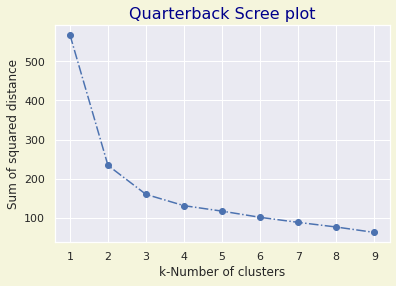

In [1248]:
sns.set(rc={'figure.facecolor':'beige'})
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(qbs_std)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 4))
plt.plot(list_k, sse, '-.o')
plt.xlabel(f'k-Number of clusters')
plt.ylabel('Sum of squared distance')
plt.title('Quarterback Scree plot', c='darkblue', size=16)
plt.show()

> The scree plot seems to confirm that the optimal amount of clusters is three.

In [1233]:
# Re-run the algoirithm with the optimal 3 clusters and group players
km = KMeans(n_clusters=3, random_state=0)
km.fit(qbs_std)

qbs['GROUP'] = km.labels_

In [1234]:
qbs.groupby('GROUP').mean().style.apply(highlight_max)

> From the max-values indicated in each column, GROUP 2 tops each category except for `pass_yds` (passing yards) and the only two negative scoring categories `pass_int` (pass interceptions) and `fl` (fumbles lost). Most of all, the highest average Draftkings points (`dkpt`) belong to GROUP 2. The second best group is GROUP 1, with a much higher `dkpt` than GROUP 0. So let's take a look at the players in each group.

In [1235]:
qbs.loc[:,'player'] = nfl_qbs.loc[:, 'player']

In [1237]:
print(f'Tier 1 QBs:\n\n {list(qbs.player.loc[qbs.GROUP == 2])}\n' + '-'*100)
print(f'Tier 2 QBs:\n\n {list(qbs.player.loc[qbs.GROUP == 1])}\n' + '-'*100)
print(f'Tier 3 QBs:\n\n {list(qbs.player.loc[qbs.GROUP == 0])}\n' + '-'*100)

Tier 1 QBs:

 ['Lamar Jackson', 'Deshaun Watson', 'Josh Allen', 'Kyler Murray']
----------------------------------------------------------------------------------------------------
Tier 2 QBs:

 ['Dak Prescott', 'Russell Wilson', 'Jameis Winston', 'Patrick Mahomes', 'Aaron Rodgers', 'Carson Wentz', 'Matt Ryan', 'Tom Brady', 'Jared Goff', 'Jimmy Garoppolo', 'Derek Carr', 'Kirk Cousins', 'Ryan Fitzpatrick', 'Philip Rivers', 'Baker Mayfield', 'Gardner Minshew', 'Drew Brees', 'Ryan Tannehill', 'Jacoby Brissett', 'Daniel Jones', 'Andy Dalton', 'Mitchell Trubisky', 'Sam Darnold', 'Kyle Allen', 'Matthew Stafford']
----------------------------------------------------------------------------------------------------
Tier 3 QBs:

 ['Mason Rudolph', 'Case Keenum', 'Teddy Bridgewater', 'Joe Flacco', 'Marcus Mariota', 'Taysom Hill', 'Dwayne Haskins', 'Drew Lock', 'Jeff Driskel', 'David Blough', 'Eli Manning', 'Devlin Hodges', 'Matt Moore', 'Nick Foles', 'Brandon Allen', 'Matt Schaub', 'Chase Daniel'

>## Hierarchical clustering

In [1238]:
def run_agglo(data, n_clusters=2, rounds=2, linkage='complete', affinity='cosine'):
    df = pd.DataFrame()
    
    for j in range(rounds):
        for i in range(2,n_clusters + 1):
            agg = AgglomerativeClustering(linkage=linkage, 
                                          affinity=affinity,
                                          n_clusters=i).fit_predict(data)
            score = metrics.silhouette_score(data, agg, metric='euclidean')
            df.loc[f"{i}-Cluster Silhouette score", f"Round {j+1}"] = round(score,3)
    return df

In [1239]:
run_agglo(qbs_std, 6, 5, 'complete', 'euclidean').style.apply(highlight_max)

> Every round of our hierarchical clustering algorithm also suggests three 'optimal' clusters.

In [1241]:
# Re-run the algorithm with the 'optimal' 3 clusters and then group players
agg = AgglomerativeClustering(n_clusters=3)
agg.fit(qbs_std)

qbs['GROUP'] = agg.labels_
qbs.groupby('GROUP').mean().style.apply(highlight_max)

In [1242]:
print(f'Tier 1 QBs:\n\n {list(qbs.player.loc[qbs.GROUP == 2])}\n' + '-'*100)
print(f'Tier 2 QBs:\n\n {list(qbs.player.loc[qbs.GROUP == 0])}\n' + '-'*100)
print(f'Tier 3 QBs:\n\n {list(qbs.player.loc[qbs.GROUP == 1])}\n' + '-'*100)

Tier 1 QBs:

 ['Lamar Jackson', 'Deshaun Watson', 'Josh Allen']
----------------------------------------------------------------------------------------------------
Tier 2 QBs:

 ['Dak Prescott', 'Russell Wilson', 'Jameis Winston', 'Patrick Mahomes', 'Kyler Murray', 'Aaron Rodgers', 'Carson Wentz', 'Matt Ryan', 'Tom Brady', 'Jared Goff', 'Jimmy Garoppolo', 'Derek Carr', 'Kirk Cousins', 'Ryan Fitzpatrick', 'Philip Rivers', 'Baker Mayfield', 'Gardner Minshew', 'Drew Brees', 'Ryan Tannehill', 'Jacoby Brissett', 'Daniel Jones', 'Andy Dalton', 'Mitchell Trubisky', 'Sam Darnold', 'Kyle Allen']
----------------------------------------------------------------------------------------------------
Tier 3 QBs:

 ['Matthew Stafford', 'Mason Rudolph', 'Case Keenum', 'Teddy Bridgewater', 'Joe Flacco', 'Marcus Mariota', 'Taysom Hill', 'Dwayne Haskins', 'Drew Lock', 'Jeff Driskel', 'David Blough', 'Eli Manning', 'Devlin Hodges', 'Matt Moore', 'Nick Foles', 'Brandon Allen', 'Matt Schaub', 'Chase Daniel'

> With the Agglomerative clustering algorithm there are a few noticeable differences than the k-means clustering algorithm, namely that Kyler Murray has been dropped from Tier 1 to Tier 2 and Mathew Stafford was dropped from Tier 2 to Tier 3.

>## DBSCAN

In [1243]:
def run_dbscan(data, eps=1, min_samples=5):
    df = pd.DataFrame()
    
    for j in np.arange(0.2,eps,0.2):
        for i in range(1, min_samples+1):
            db = DBSCAN(eps=j, min_samples=i).fit_predict(data)
            score = metrics.silhouette_score(data, db, metric='euclidean')
            df.loc[f"{i}-sample Silhouette score", f"epsilon {round(j,1)}"] = round(score,3)
    return df

In [1244]:
run_dbscan(qbs_std, eps=2, min_samples=10).style.apply(highlight_max)

In [1012]:
db = DBSCAN(eps=1.6, min_samples=9).fit(qbs_std)

qbs['GROUP'] = db.labels_
qbs.groupby('GROUP').mean().style.apply(highlight_max)

>## Gaussian Mixture Models (GMM)

In [1245]:
def run_gmm(data, n_components=3, rounds=2):
    df = pd.DataFrame()
    
    for j in range(rounds):
        for i in range(n_components):
            gmm = GaussianMixture(n_components=n_components, n_init=1).fit_predict(data)
            score = metrics.silhouette_score(data, gmm, metric='euclidean')
            df.loc[f"{i}-Cluster Silhouette score", f"Round {j+1}"] = round(score,3)
    return df

In [1246]:
run_gmm(qbs_std, n_components=6, rounds=6).style.apply(highlight_max)

> Although the DBSCAN clustering algorithm has comaparable silhouette scores as the previous algorithms, when we group by labels, we see that the top performing class is really just the mean statistics for a bunch of non-clustered players (indicated by the 'noise' classification of -1). The unpredictability of the GMM from one round to the next also makes it unreliable. Therefore, from here on, we will use the k-means and agglomerative clustering algorithms only.

In [1254]:
# Re-run the k-menas algoirithm with the optimal 3 clusters for plotting purposes
km = KMeans(n_clusters=3, random_state=0)
km.fit(qbs_std)

qbs['GROUP'] = km.labels_

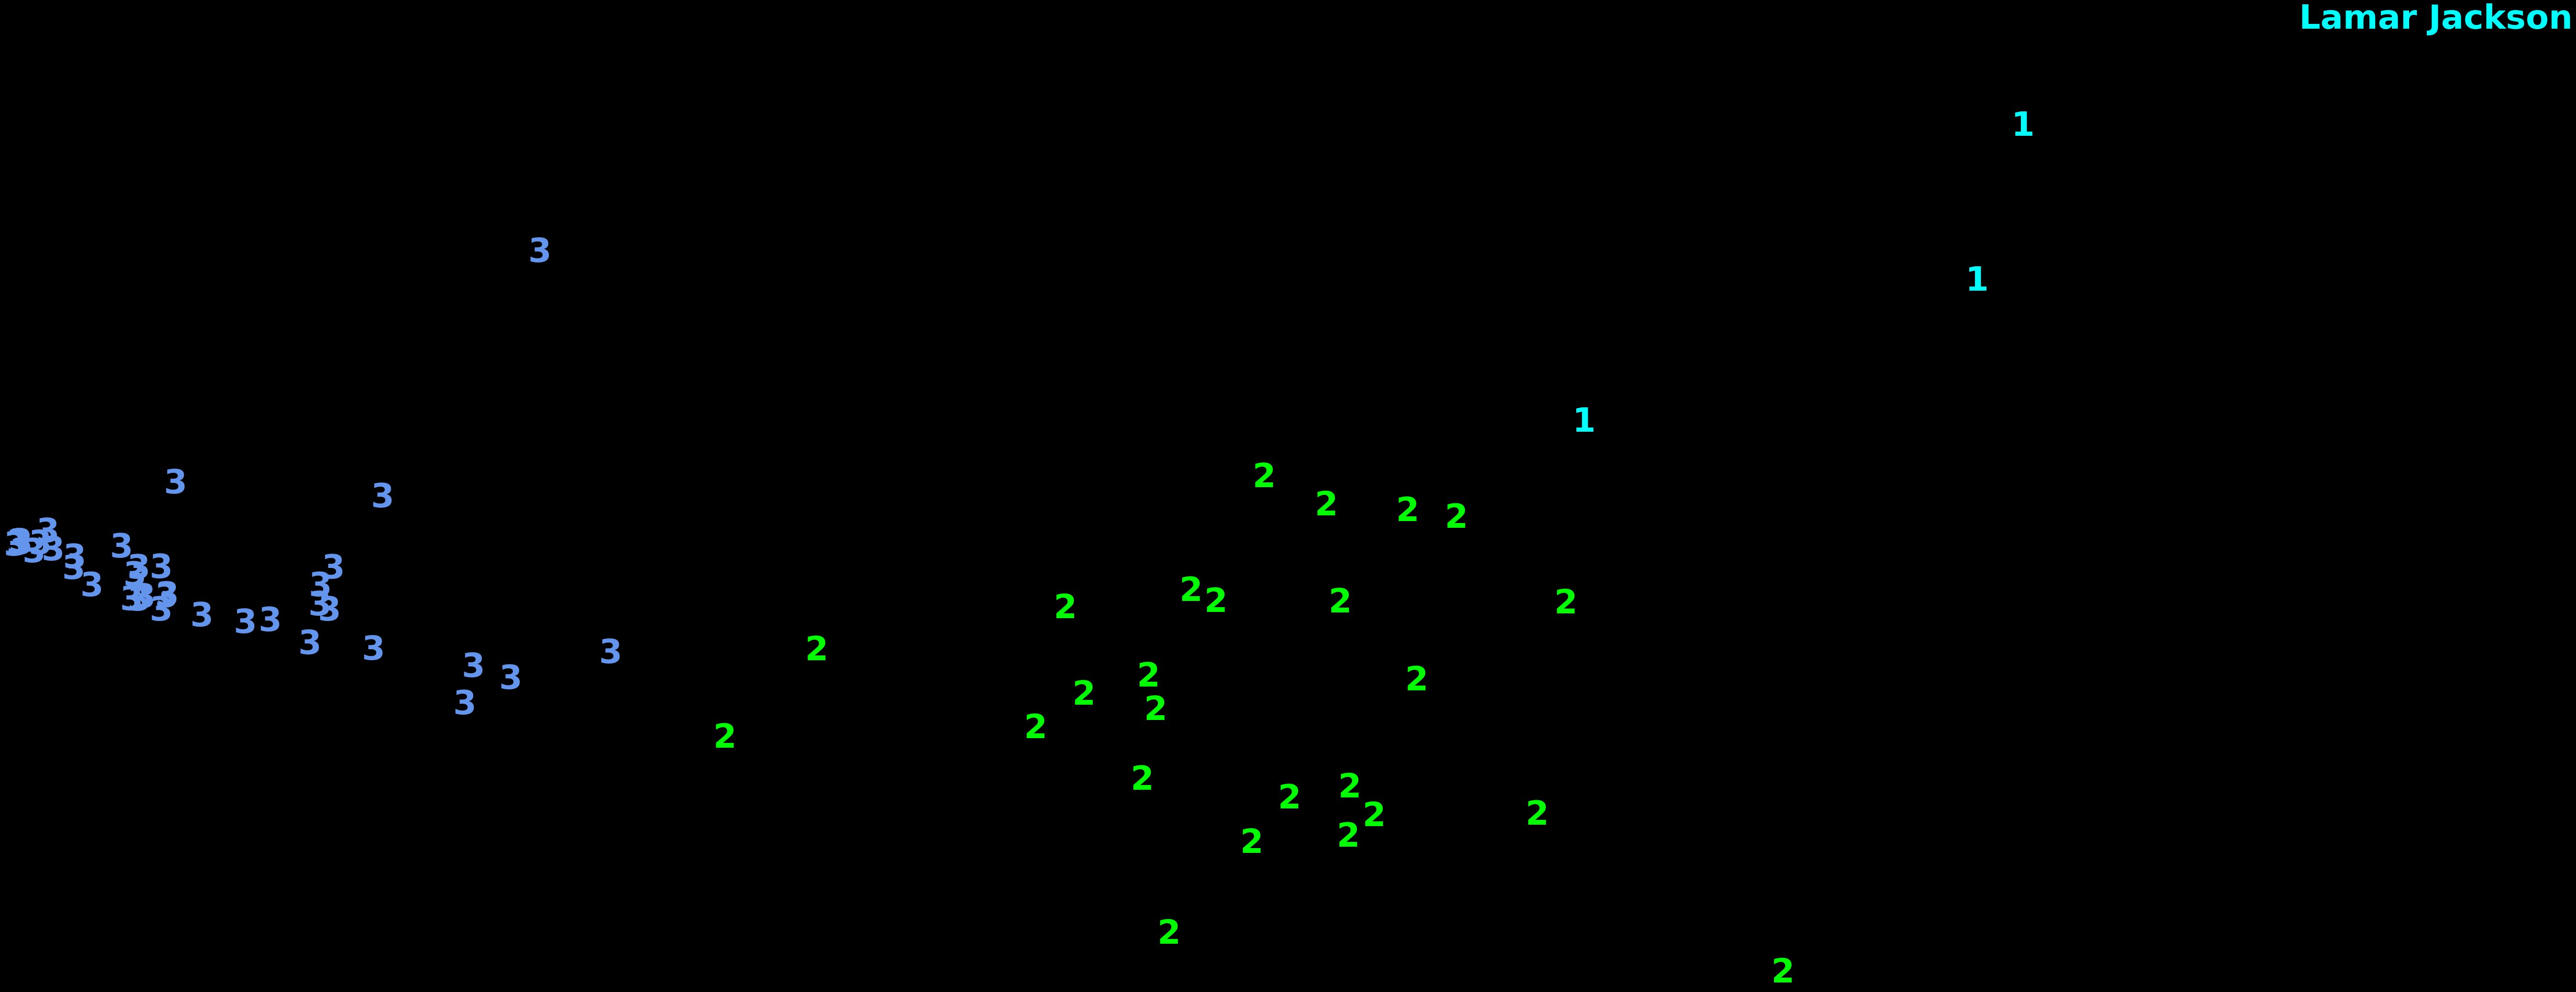

In [1258]:
# Reduce the dimensions to allow for a 2-D visualization
pca = PCA(n_components=2).fit_transform(qbs_std)
tier_dict = {2:1, 1:2, 0:3}

with plt.style.context('dark_background'):
    plt.figure(figsize=(10,5))
    colours = ['cornflowerblue','lime','cyan','lemonchiffon','hotpink']
    for i in range(pca.shape[0]):
        plt.text(pca[i, 0], pca[i, 1], str(qbs.player[i] if i==0 else tier_dict[qbs.GROUP[i]]),
                 color=colours[qbs.GROUP[i]],
                 fontdict={'weight': 'bold', 'size': 70}
            )

    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()

# Runningback

In [1259]:
# Selecting only RBs
nfl_rbs = nfl.loc[nfl.position == 'RB'].reset_index(drop=True)

nfl_rbs.head(2)

player position   g  gs  pass_cmp  pass_att  pass_yds  \
0  Christian McCaffrey  RB       16  16  0         2         0          
1  Derrick Henry        RB       15  15  0         0         0          

   pass_td  pass_int  rush_att  ...  rec_yds  rec_y/r  rec_td  fmb  \
0  0        0         287       ...  1005     8.66     4       1     
1  0        0         303       ...  206      11.44    2       5     

   fumbles_lost  scoring_td  fantpt    ppr   dkpt   fdpt  
0  0             19          355     471.2  477.2  413.2  
1  3             18          277     294.6  303.6  285.6  

[2 rows x 25 columns]

In [1260]:
# Standarizing the numeric features and reducing the feature set relevant to DK scoring stats
## Since 'scoring_td' captures both 'rush_td' and 'rec_td', we'll exclude the latter two
rbs = nfl_rbs[['rush_yds','receptions','rec_yds','fumbles_lost','scoring_td','dkpt']]
rbs_std = scaler.fit_transform(rbs)

In [1261]:
# We'll run the algorithm five times, allowing the built in 'kmeans++' default parameter to 
# run each round the default `n_init=10` times per round to randomize starting centroid position

df = run_kmeans(data=rbs_std, max_clusters=6,rounds=5)
df.style.apply(highlight_max)

> With our running backs, every round of the k-means algorithm determined that two clusters is the best choice for *k*. We view a scree plot below.

Text(0.5, 1.0, 'Running Back Scree plot')

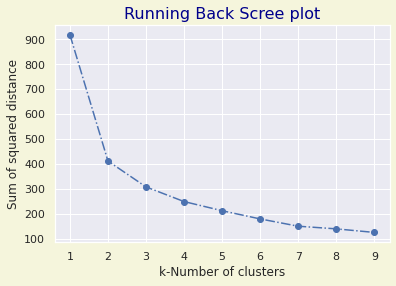

In [1263]:
sns.set(rc={'figure.facecolor':'beige'})
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(rbs_std)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 4))
plt.plot(list_k, sse, '-.o')
plt.xlabel(f'k-Number of clusters')
plt.ylabel('Sum of squared distance')
plt.title('Running Back Scree plot', c='darkblue', size=16)

> The scree plot seems to suggest 'at least' three clusters with upwards of five.

In [1270]:
# Run the algorithm with the silhouette scores' 'optimal' 2 clusters and then group players
km = KMeans(n_clusters=2, random_state=0)
km.fit(rbs_std)

rbs['GROUP'] = km.labels_
rbs.groupby('GROUP').mean().style.apply(highlight_max)

> From the max-values indicated in each column, GROUP 0 tops each and every category, including `fumbles_lost`), the only negative scoring statistic in this feature set. In fact, there might be too much separation between the tiers as GROUP 1 was outscored by almost *6 times*! This makes me wonder if any running back worth a damn might be grouped in GROUP 0 while players not worth rostering are in GROUP 1.

In [1271]:
# Add a player column to the rbs dataframe
rbs.loc[:,'player'] = nfl_rbs.loc[:, 'player']

In [1272]:
print(f'Tier 1 RBs:\n\n {list(rbs.player.loc[rbs.GROUP == 1])}\n' + '-'*100)
print(f'Tier 2 RBs:\n\n {list(rbs.player.loc[rbs.GROUP == 0])}\n' + '-'*100)

Tier 1 RBs:

 ['Jordan Howard', 'Gus Edwards', 'DeAndre Washington', 'Matt Breida', 'Frank Gore', 'Kerryon Johnson', 'Rex Burkhead', 'Tony Pollard', 'Boston Scott', 'Chase Edmonds', 'Rashaad Penny', 'Kareem Hunt', 'Alexander Mattison', 'Malcolm Brown', 'Brian Hill', 'Benny Snell', 'Darrel Williams', 'Chris Thompson', 'Derrius Guice', 'J.D. McKissic', 'Mike Boone', 'Jalen Richard', 'Jordan Wilkins', 'Patrick Laird', 'Jeff Wilson', 'Brandon Bolden', 'Justice Hill', 'Bo Scarbrough', 'Dion Lewis', 'Dare Ogunbowale', 'Kalen Ballage', 'Giovani Bernard', 'Ryquell Armstead', 'Wayne Gallman', 'Ty Johnson', 'Jonathan Williams', 'Kyle Juszczyk', 'Qadree Ollison', 'Mark Walton', 'Dontrell Hilliard', 'Bilal Powell', 'Ito Smith', 'Ameer Abdullah', 'Myles Gaskin', 'Reggie Bonnafon', 'Darwin Thompson', 'Justin Jackson', 'C.J. Ham', 'Ty Montgomery', 'C.J. Prosise', 'Darrell Henderson', 'Travis Homer', 'T.J. Yeldon', 'Andrew Beck', 'Wendell Smallwood', 'Trey Edmunds', 'Wes Hills', 'Kerrith Whyte', 'Alec

> As an avid fantasy football player, these results are a bit unsatisfying. I worry my concerns from before have been confirmed. There is a clear distinction between the top running backs in Tier 1 from the lesser backs within that same tier. We can see the difference between two top tier backs below, with Christian McCaffrey having scored more than triple what Peyton Barber did over the course of the season despite being grouped into the same tier. I'll run the algorithm again with three and four clusters to see if we get more separation *within* the previous tiers rather than *between* them.

In [1273]:
# Re-run the algoirithm with 3 clusters and group players
km = KMeans(n_clusters=3, random_state=0)
km.fit(rbs_std)

rbs['GROUP'] = km.labels_
rbs.groupby('GROUP').mean().style.apply(highlight_max)

In [1274]:
print(f'Tier 1 RBs:\n\n {list(rbs.player.loc[rbs.GROUP == 2])}\n' + '-'*100)
print(f'Tier 2 RBs:\n\n {list(rbs.player.loc[rbs.GROUP == 0])}\n' + '-'*100)
print(f'Tier 3 RBs:\n\n {list(rbs.player.loc[rbs.GROUP == 1])}\n' + '-'*100)

Tier 1 RBs:

 ['Christian McCaffrey', 'Derrick Henry', 'Aaron Jones', 'Ezekiel Elliott', 'Dalvin Cook', 'Nick Chubb', 'Austin Ekeler', 'Mark Ingram', 'Chris Carson', 'Saquon Barkley', 'Todd Gurley', 'Leonard Fournette', 'Miles Sanders', 'Alvin Kamara', 'Kenyan Drake', "Le'Veon Bell", 'Devonta Freeman', 'Melvin Gordon', 'James White']
----------------------------------------------------------------------------------------------------
Tier 2 RBs:

 ['Joe Mixon', 'Josh Jacobs', 'Marlon Mack', 'Phillip Lindsay', 'Raheem Mostert', 'David Montgomery', 'Carlos Hyde', 'Sony Michel', 'Ronald Jones', 'Adrian Peterson', 'Latavius Murray', 'Devin Singletary', 'Tevin Coleman', 'James Conner', 'Damien Williams', 'Duke Johnson', 'Jamaal Williams', 'David Johnson', 'Peyton Barber', 'Jordan Howard', 'Royce Freeman', 'LeSean McCoy', 'Gus Edwards', 'DeAndre Washington', 'Tarik Cohen', 'Matt Breida', 'Frank Gore', 'Kerryon Johnson', 'Rex Burkhead', 'Nyheim Hines', 'Tony Pollard', 'Boston Scott', 'Rashaad 

> This looks a lot better. A distinction has been made between the top two tiers and both are full of roster-worthy, and down right start-able, players. Still, you do see some full-time, workhorse runningbacks grouped with split-time and backup running backs in Tier 2. The fact that Joe Mixon is grouped together with backups like Tony Pollard and Kareem Hunt is a bit problematic. Next, four clusters.

In [1345]:
# Re-run the algorithm with 4 clusters
km = KMeans(n_clusters=4, random_state=1)
km.fit(rbs_std)

rbs['GROUP'] = km.labels_
rbs.groupby('GROUP').mean().style.apply(highlight_max)

In [1347]:
print(f'Tier 1 RBs:\n\n {list(rbs.player.loc[rbs.GROUP == 2])}\n' + '-'*100)
print(f'Tier 2 RBs:\n\n {list(rbs.player.loc[rbs.GROUP == 1])}\n' + '-'*100)
print(f'Tier 3 RBs:\n\n {list(rbs.player.loc[rbs.GROUP == 0])}\n' + '-'*100)
print(f'Tier 4 RBs:\n\n {list(rbs.player.loc[rbs.GROUP == 3])}\n' + '-'*100)

Tier 1 RBs:

 ['Christian McCaffrey', 'Derrick Henry', 'Aaron Jones', 'Ezekiel Elliott', 'Dalvin Cook', 'Nick Chubb', 'Austin Ekeler', 'Mark Ingram', 'Chris Carson', 'Todd Gurley', 'Melvin Gordon']
----------------------------------------------------------------------------------------------------
Tier 2 RBs:

 ['Saquon Barkley', 'Joe Mixon', 'Leonard Fournette', 'Josh Jacobs', 'Miles Sanders', 'Alvin Kamara', 'Marlon Mack', 'Kenyan Drake', 'Phillip Lindsay', 'Raheem Mostert', "Le'Veon Bell", 'David Montgomery', 'Carlos Hyde', 'Sony Michel', 'Devonta Freeman', 'Ronald Jones', 'Adrian Peterson', 'James White', 'Latavius Murray', 'Devin Singletary', 'Tevin Coleman', 'James Conner', 'Damien Williams', 'Duke Johnson', 'Jamaal Williams', 'David Johnson', 'Royce Freeman', 'LeSean McCoy', 'Tarik Cohen', 'Nyheim Hines']
----------------------------------------------------------------------------------------------------
Tier 3 RBs:

 ['Peyton Barber', 'Jordan Howard', 'Gus Edwards', 'DeAndre Wa

> Although it probably wouldn't hurt to create five tiers, I think four tiers pretty much gets it right. We have the elite, mostly healthy, workhorse backs on the top tier. Tier 2 contains the rest of the workhorse backs who just fell short of elite last year, whether due to a lack of touchdowns, like Leonard Fournette (3 TDs) or from suffering through an injury bug, like Saquon Barkley (3 full games missed). Tier 3 features back ups who split time heavily, like Matt Breida or Frank Gore. I could probably still nitpick here and there, but overall I'm satisfied with these clusters, and four clusters is also justifiable from the scree plot, which is, admittedly, subjective as a change in scale of the x and y axes could result in a different looking plot altogether.

> Let's take a look and the clustering behavior, albeit in dimensionally reduced space, for the running back clusters. First PCA then t-SNE.

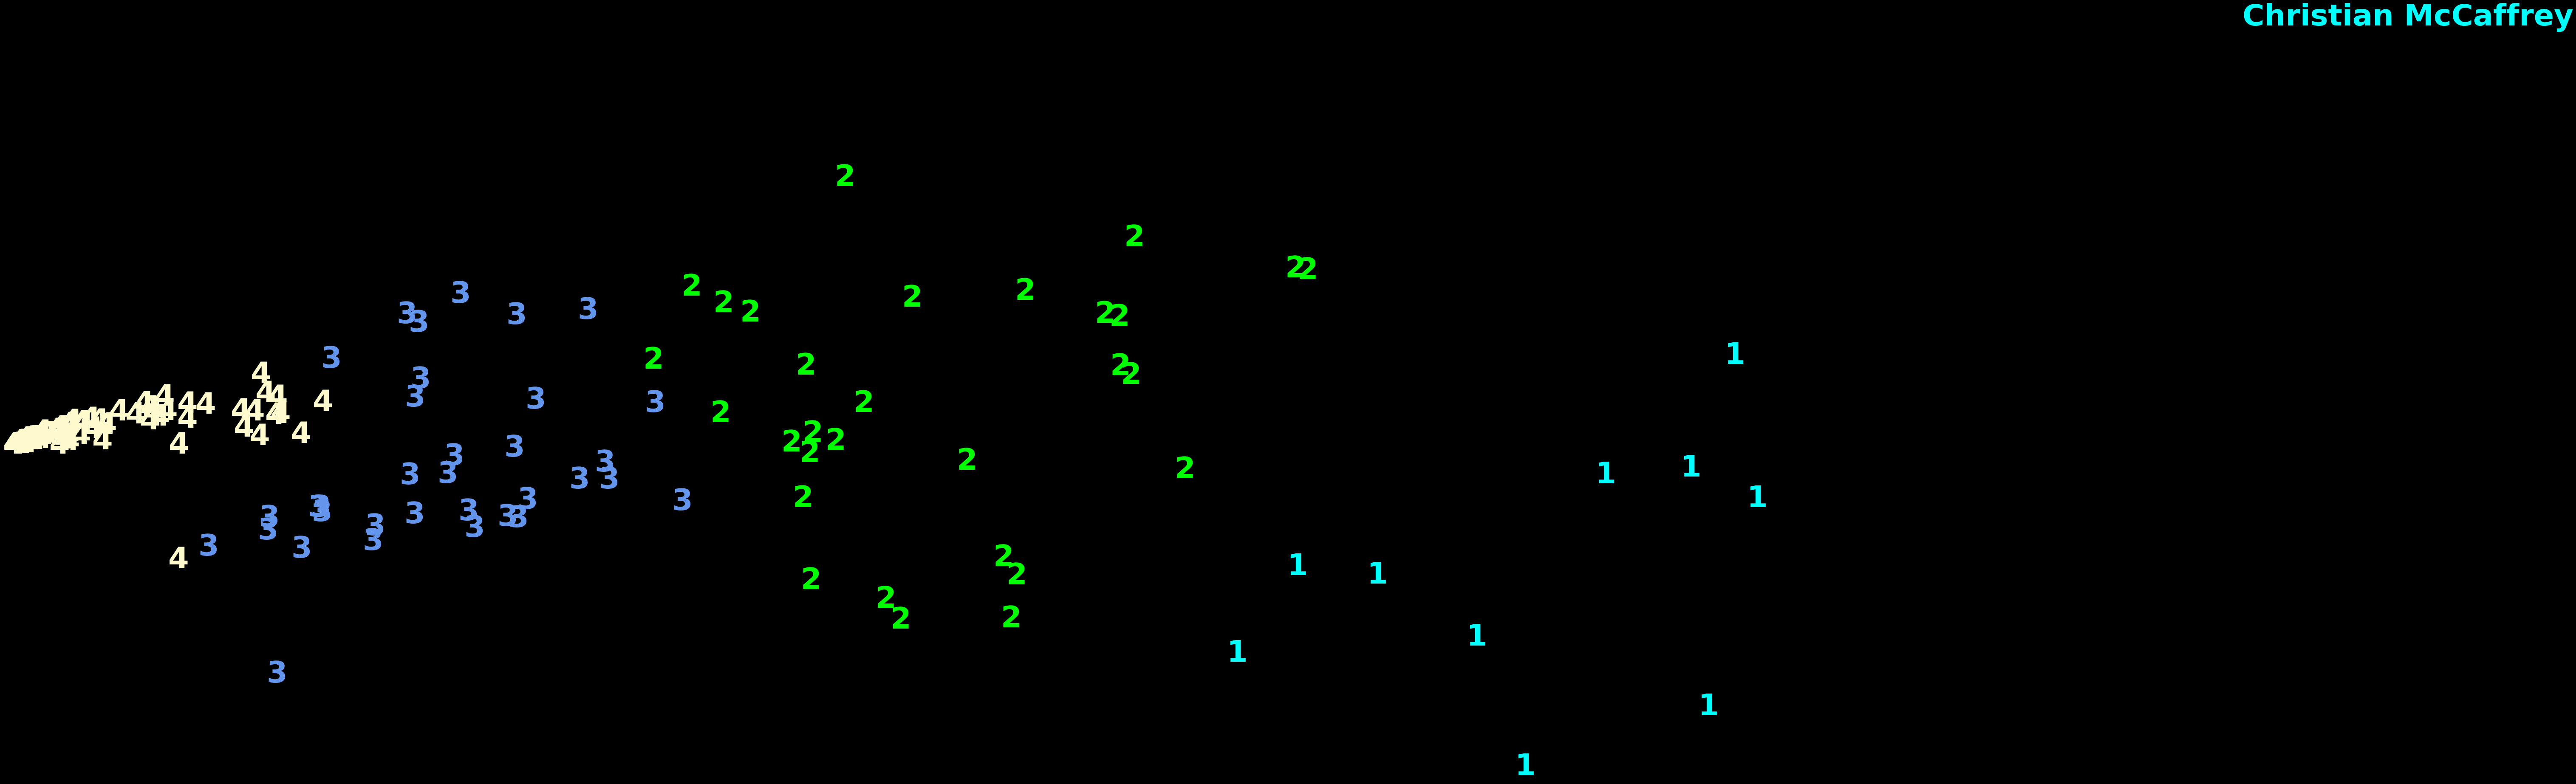

In [1354]:
# Reduce the dimensions to allow for a 2-D visualization
pca = PCA(n_components=2).fit_transform(rbs_std)
tier_dict = {2:1, 1:2, 0:3, 3:4}

with plt.style.context('dark_background'):
    plt.figure(figsize=(10,5))
    colours = ['cornflowerblue','lime','cyan','lemonchiffon','hotpink']
    for i in range(pca.shape[0]):
        plt.text(pca[i, 0], pca[i, 1], str(rbs.player[i] if i==0 else tier_dict[rbs.GROUP[i]]),
                 color=colours[rbs.GROUP[i]],
                 fontdict={'weight': 'bold', 'size': 70}
            )

    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()

In [1355]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(rbs_std)

sns.set(rc={'figure.facecolor':'k'})

pca = PCA(n_components=2).fit_transform(rbs_std)
tier_dict = {2:1, 1:2, 0:3, 3:4}

plt.figure(figsize=(10,5))
colours = ['cornflowerblue','lime','cyan','lemonchiffon','hotpink']
for i in range(tsne_results.shape[0]):
    plt.text(tsne_results[i, 0], tsne_results[i, 1], str(rbs.player[i] if i==0 else tier_dict[rbs.GROUP[i]]),
             color=colours[rbs.GROUP[i]],
             fontdict={'weight': 'bold', 'size': 100}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 153 samples in 0.001s...
[t-SNE] Computed neighbors for 153 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 153 / 153
[t-SNE] Mean sigma: 0.335018
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.057526
[t-SNE] KL divergence after 300 iterations: 0.146711


> Both plots show a nice and nearly distinct clustering of groups.

# Wide Receiver
*This one proved a bit trickier*

In [1310]:
# Selecting only WRs
nfl_wrs = nfl.loc[nfl.position == 'WR'].reset_index(drop=True)
nfl_wrs.head(2)

player position   g  gs  pass_cmp  pass_att  pass_yds  pass_td  \
0  Michael Thomas  WR       16  15  0         0         0         0         
1  Chris Godwin    WR       14  14  0         0         0         0         

   pass_int  rush_att  ...  rec_yds  rec_y/r  rec_td  fmb  fumbles_lost  \
0  0         1         ...  1725     11.58    9       1    0              
1  0         1         ...  1333     15.50    9       0    0              

   scoring_td  fantpt    ppr   dkpt   fdpt  
0  9           226     374.6  377.6  300.1  
1  9           190     276.1  279.1  233.1  

[2 rows x 25 columns]

In [1311]:
# Standarizing the numeric features and reducing the feature set relevant to DK relevant stats
## Since 'scoring_td' captures both 'rush_td' and 'rec_td', we'll exclude the latter two
wrs = nfl_wrs[['rush_yds','receptions','rec_yds','fumbles_lost','scoring_td','dkpt']]
wrs_std = scaler.fit_transform(wrs)

In [1312]:
# We'll run the algorithm five times, allowing the built in 'kmeans++' default parameter to 
# run each round the default `n_init=10` times per round to randomize starting centroid position
run_kmeans(data=wrs_std, max_clusters=6,rounds=5).style.apply(highlight_max)

In [1313]:
# Now we'll run an agglomerative clustering algorithm
run_agglo(wrs_std, 6, 5, 'complete', 'euclidean').style.apply(highlight_max)

> With wide reciever, every round of both the k-means and agglomerative clustering algorithms determined that three clusters is the best choice for *k*. We view a scree plot below.

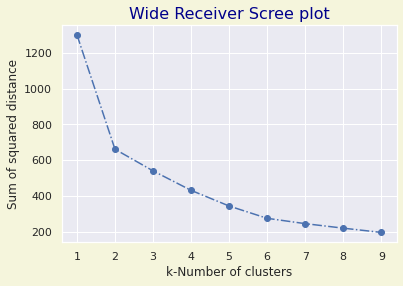

In [1314]:
sns.set(rc={'figure.facecolor':'beige'})
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(wrs_std)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 4))
plt.plot(list_k, sse, '-.o')
plt.xlabel(f'k-Number of clusters')
plt.ylabel('Sum of squared distance')
plt.title('Wide Receiver Scree plot', c='darkblue', size=16)
plt.show()

> The scree plot seems to suggest upwards of 5 or 6 clusters. We'll first run the algorithm with the three clusters, as indicated by silhouette scores, to see how it satisfies intuition.

In [1315]:
# Run the algoirithm with the silhouette scores 'optimal' 2 clusters and group players
km = KMeans(n_clusters=3, random_state=0)
km.fit(wrs_std)

wrs['GROUP'] = km.labels_
wrs.groupby('GROUP').mean().style.apply(highlight_max)

> From the max-values indicated in each column, GROUP 0 tops the `dkpt` column and leads in both pass catching (`receptions` and `rec_yds`) categories.

In [1316]:
# Add a player column to the rbs dataframe to allow for listing of players
wrs.loc[:,'player'] = nfl_wrs.loc[:, 'player']

In [1317]:
print(f'Tier 1 WRs:\n\n {list(wrs.player.loc[wrs.GROUP == 0])}\n' + '-'*100)
print(f'Tier 2 WRs:\n\n {list(wrs.player.loc[wrs.GROUP == 2])}\n' + '-'*100)
print(f'Tier 3 WRs:\n\n {list(wrs.player.loc[wrs.GROUP == 1])}\n' + '-'*100)

Tier 1 WRs:

 ['Michael Thomas', 'Chris Godwin', 'Kenny Golladay', 'Cooper Kupp', 'Julio Jones', 'DeVante Parker', 'Amari Cooper', 'Mike Evans', 'A.J. Brown', 'DeAndre Hopkins', 'Keenan Allen', 'Allen Robinson', 'Julian Edelman', 'Jarvis Landry', 'Tyler Lockett', 'DJ Chark', 'Courtland Sutton', 'John Brown', 'Michael Gallup', 'D.J. Moore', 'Calvin Ridley', 'Terry McLaurin', 'Marvin Jones', 'Tyreek Hill', 'Davante Adams', 'Odell Beckham', 'Emmanuel Sanders', 'Darius Slayton', 'Jamison Crowder', 'Cole Beasley', 'Mike Williams', 'Robby Anderson', 'Chris Conley', 'Golden Tate', 'Larry Fitzgerald', 'Breshad Perriman', 'Tyrell Williams', 'Marquise Brown', 'Randall Cobb', 'Zach Pascal', 'Dede Westbrook', 'James Washington', 'Sammy Watkins', 'Will Fuller', 'Hunter Renfrow', 'Adam Thielen', 'T.Y. Hilton', 'Kenny Stills', 'Danny Amendola', 'Alshon Jeffery', 'Anthony Miller', 'JuJu Smith-Schuster', 'Mohamed Sanu']
-----------------------------------------------------------------------------------

> With Mohamed Sanu (59 receptions, 520 receiving yards and 2 touchdowns) grouped together with Michael Thomas (149 receptions, 1725 receiving yards and 9 touchdowns), I think the first tier could use some more separation. We'll now explore larger clusters as suggested by the scree plot.

In [1318]:
# Re-run the algoirithm with 5 clusters and group players
km = KMeans(n_clusters=5, random_state=0)
km.fit(wrs_std)

wrs['GROUP'] = km.labels_
wrs.groupby('GROUP').mean().style.apply(highlight_max)

In [1319]:
print(f'Tier 1 WRs:\n\n {list(wrs.player.loc[wrs.GROUP == 3])}\n' + '-'*100)
print(f'Tier 2 WRs:\n\n {list(wrs.player.loc[wrs.GROUP == 1])}\n' + '-'*100)
print(f'Tier 3 WRs:\n\n {list(wrs.player.loc[wrs.GROUP == 0])}\n' + '-'*100)
print(f'Tier 4 WRs:\n\n {list(wrs.player.loc[wrs.GROUP == 4])}\n' + '-'*100)
print(f'Tier 5 WRs:\n\n {list(wrs.player.loc[wrs.GROUP == 2])}\n' + '-'*100)

Tier 1 WRs:

 ['Michael Thomas', 'Chris Godwin', 'Kenny Golladay', 'Cooper Kupp', 'Julio Jones', 'DeVante Parker', 'Amari Cooper', 'Mike Evans', 'A.J. Brown', 'DeAndre Hopkins', 'Keenan Allen', 'Allen Robinson', 'Julian Edelman', 'Jarvis Landry', 'Tyler Lockett', 'DJ Chark', 'Courtland Sutton', 'John Brown', 'Michael Gallup', 'D.J. Moore', 'Calvin Ridley', 'Terry McLaurin', 'Marvin Jones', 'Tyreek Hill', 'Davante Adams', 'Odell Beckham', 'Emmanuel Sanders', 'Darius Slayton', 'Jamison Crowder', 'Cole Beasley']
----------------------------------------------------------------------------------------------------
Tier 2 WRs:

 ['Robert Woods', 'Deebo Samuel', 'Curtis Samuel', 'Christian Kirk', 'Sterling Shepard', 'Steven Sims', 'Cordarrelle Patterson']
----------------------------------------------------------------------------------------------------
Tier 3 WRs:

 ['Mike Williams', 'Robby Anderson', 'Chris Conley', 'Breshad Perriman', 'Tyrell Williams', 'Marquise Brown', 'Zach Pascal', 'De

> I could *definitely* nitpick these clustered groups. Stefon Diggs (61 receptions, 1130 receiving yards, 6 touchdowns and 218.1 DK points) is grouped in Tier 4 while Cordarrelle Patterson (11 receptions, 83 receiving yards, 1 touchdown and a mere *38.6 DK points*) is grouped in Tier 2! How can this be? I suspect either `fumbles_lost`, worth a *whopping* **-1** Draftkings points each, or `rush_yds` is distorting which players are actually similar to each other from a scoring standpoint. Diggs has 3 lost fumbles to Patterson's zero while they both rank top ten in rushing yards for receivers (see below). Notice in the table below that a lot of the players have been grouped into GROUP 1 (Tier 2) while Trevor Davis and Diggs, with 2 and 3 fumbles respectively, have both been grouped 4 (Tier 4).

In [1320]:
# Top 10 WRs by rushing yards
wrs.sort_values(by='rush_yds', ascending=False).head(10).style.apply(lambda x: ['background: lightsteelblue' if x.name == 'rush_yds' else '' for i in x])

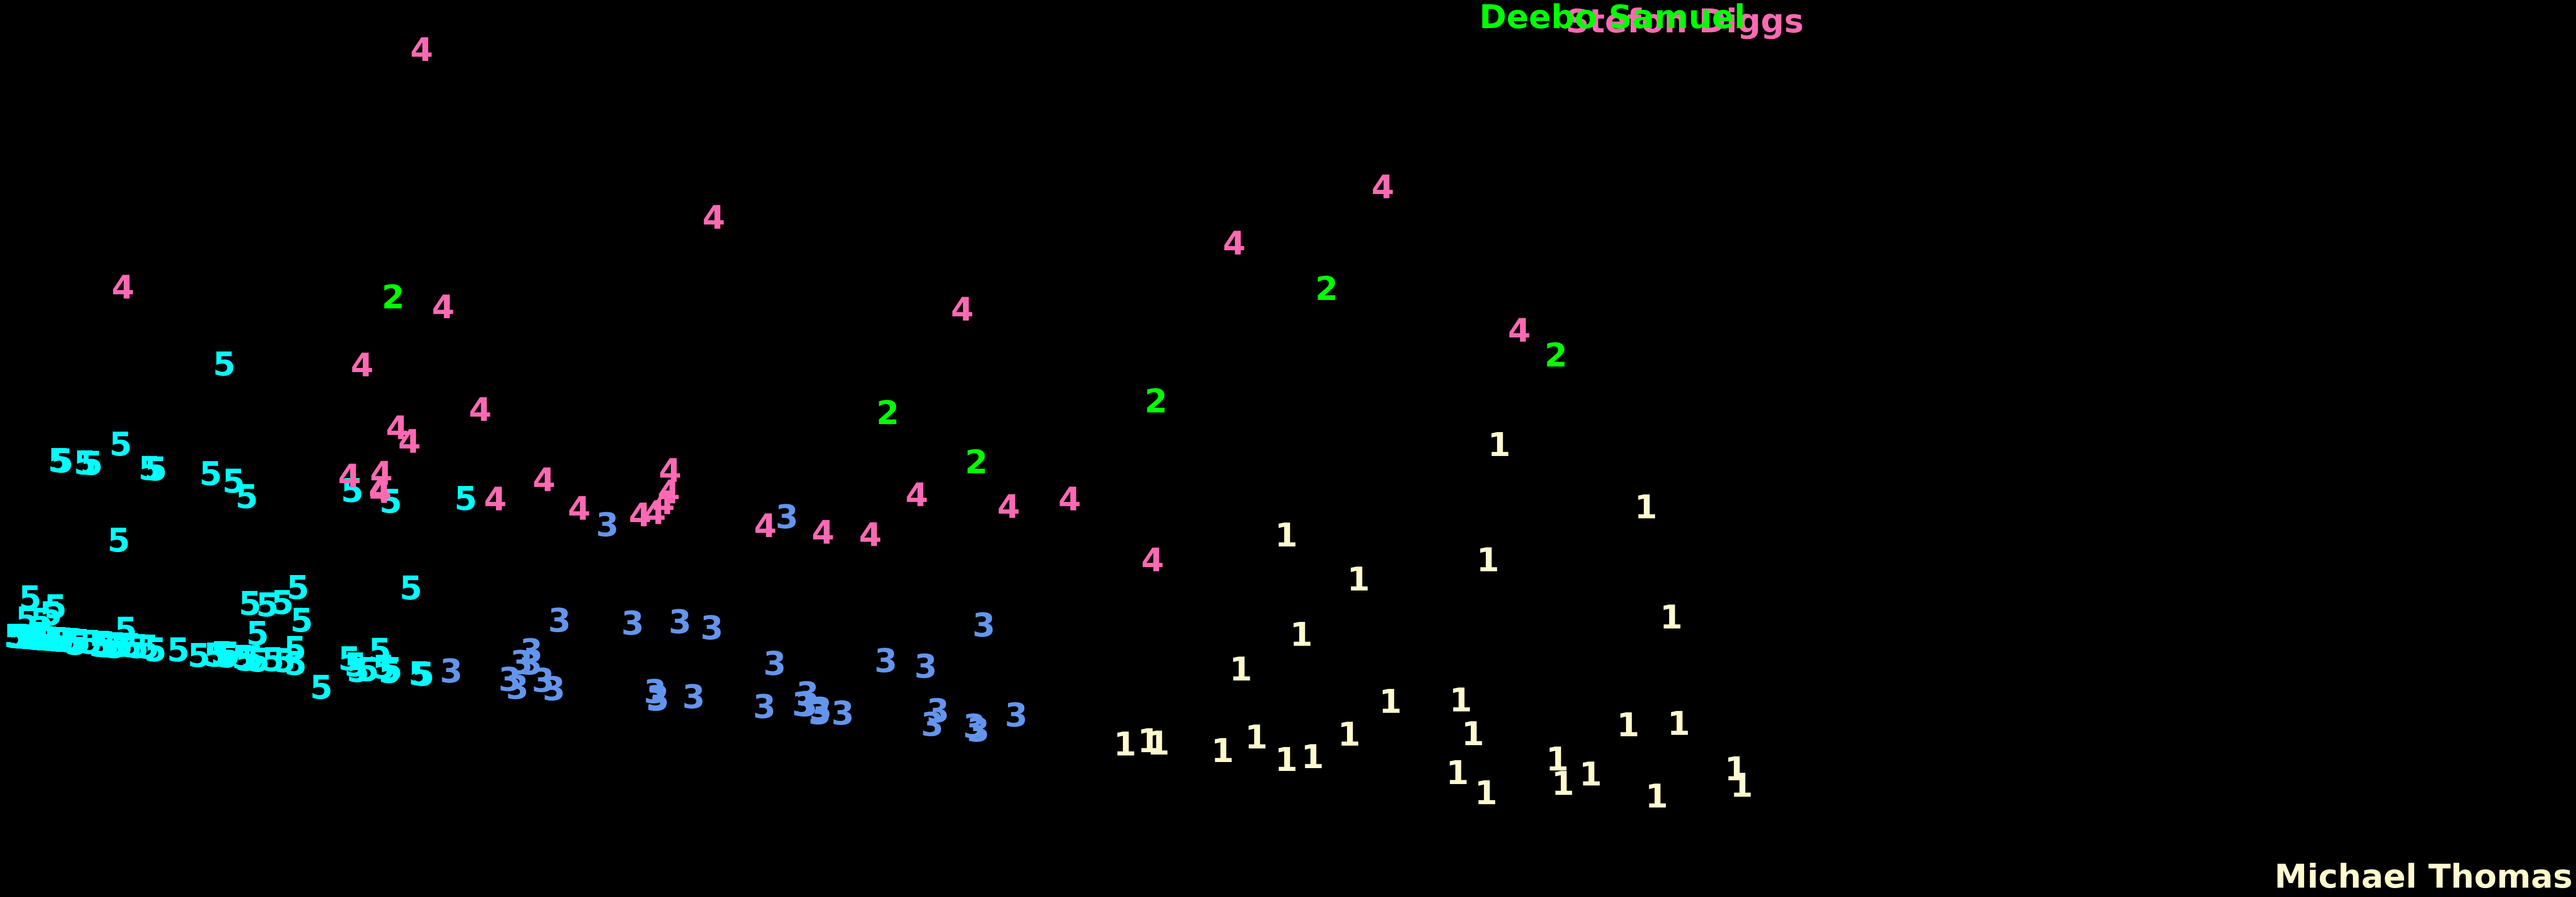

In [1321]:
pca = PCA(n_components=2).fit_transform(wrs_std)
tier_dict = {3:1, 1:2, 0:3, 4:4, 2:5}

with plt.style.context('dark_background'):
    plt.figure(figsize=(10,5))
    colours = ['cornflowerblue','lime','cyan','lemonchiffon','hotpink']
    for i in range(pca.shape[0]):
        plt.text(pca[i, 0], pca[i, 1], str(wrs.player[i] if wrs.player[i]=='Stefon Diggs' or wrs.player[i]=='Michael Thomas' or wrs.player[i]== 'Deebo Samuel' else tier_dict[wrs.GROUP[i]]),
                 color=colours[wrs.GROUP[i]],
                 fontdict={'weight': 'bold', 'size': 70}
            )

    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()

> Although this is a dimensionally reduced visualization, the *apparent* outlier is Michael Thomas (149 receptions, 1725 receiving yards and 9 touchdowns). This is because he is simply heads and shoulders above the rest of his peers. However, Stefon Diggs and Deebo Samuel were grouped in separate tiers despite displaying similar outlier behavior. As I mentioned before, I suspect this is due to Diggs' `fumbles_lost` weighing more heavily against him than would actually be the case in true fantasy scoring. Let's take a look at a t-SNE dimensionally reduced visulaization so we can gain another perspective.

In [1322]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(wrs_std)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 217 samples in 0.001s...
[t-SNE] Computed neighbors for 217 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 217 / 217
[t-SNE] Mean sigma: 0.263013
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.030514
[t-SNE] KL divergence after 300 iterations: 0.253522


In [1323]:
sns.set(rc={'figure.facecolor':'k'})

pca = PCA(n_components=2).fit_transform(wrs_std)
tier_dict = {3:1, 1:2, 0:3, 4:4, 2:5}

plt.figure(figsize=(10,5))
colours = ['cornflowerblue','lime','cyan','lemonchiffon','hotpink']
for i in range(tsne_results.shape[0]):
    plt.text(tsne_results[i, 0], tsne_results[i, 1], str(wrs.player[i] if wrs.player[i]=='Stefon Diggs' or wrs.player[i]=='Michael Thomas' or wrs.player[i]== 'Deebo Samuel' else tier_dict[wrs.GROUP[i]]),
             color=colours[wrs.GROUP[i]],
             fontdict={'weight': 'bold', 'size': 100}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

> While recognizing again that this is a dimensionally reduced visualization, there seems to be some clustering issues between tiers 4 and 5. Also, peripheral clustering for tiers 2 and 4, along with the aforementioned low, Tier 4 status for Stefon Diggs remain suspicious. We'll now remove `fumbles_lost` from our feature set to see if this corrects Diggs' low ranking.

In [1326]:
# Removing 'fumbles_lost' from the feature set
wrs = nfl_wrs[['rush_yds','receptions','rec_yds','scoring_td','dkpt']]
wrs_std = scaler.fit_transform(wrs)

In [1327]:
# Re-run the algorithm with 5 clusters and group players
km = KMeans(n_clusters=5, random_state=0)
km.fit(wrs_std)

wrs['GROUP'] = km.labels_
wrs.groupby('GROUP').mean().style.apply(highlight_max)

In [1328]:
# Add a player column to the wrs dataframe
wrs.loc[:,'player'] = nfl_wrs.loc[:, 'player']

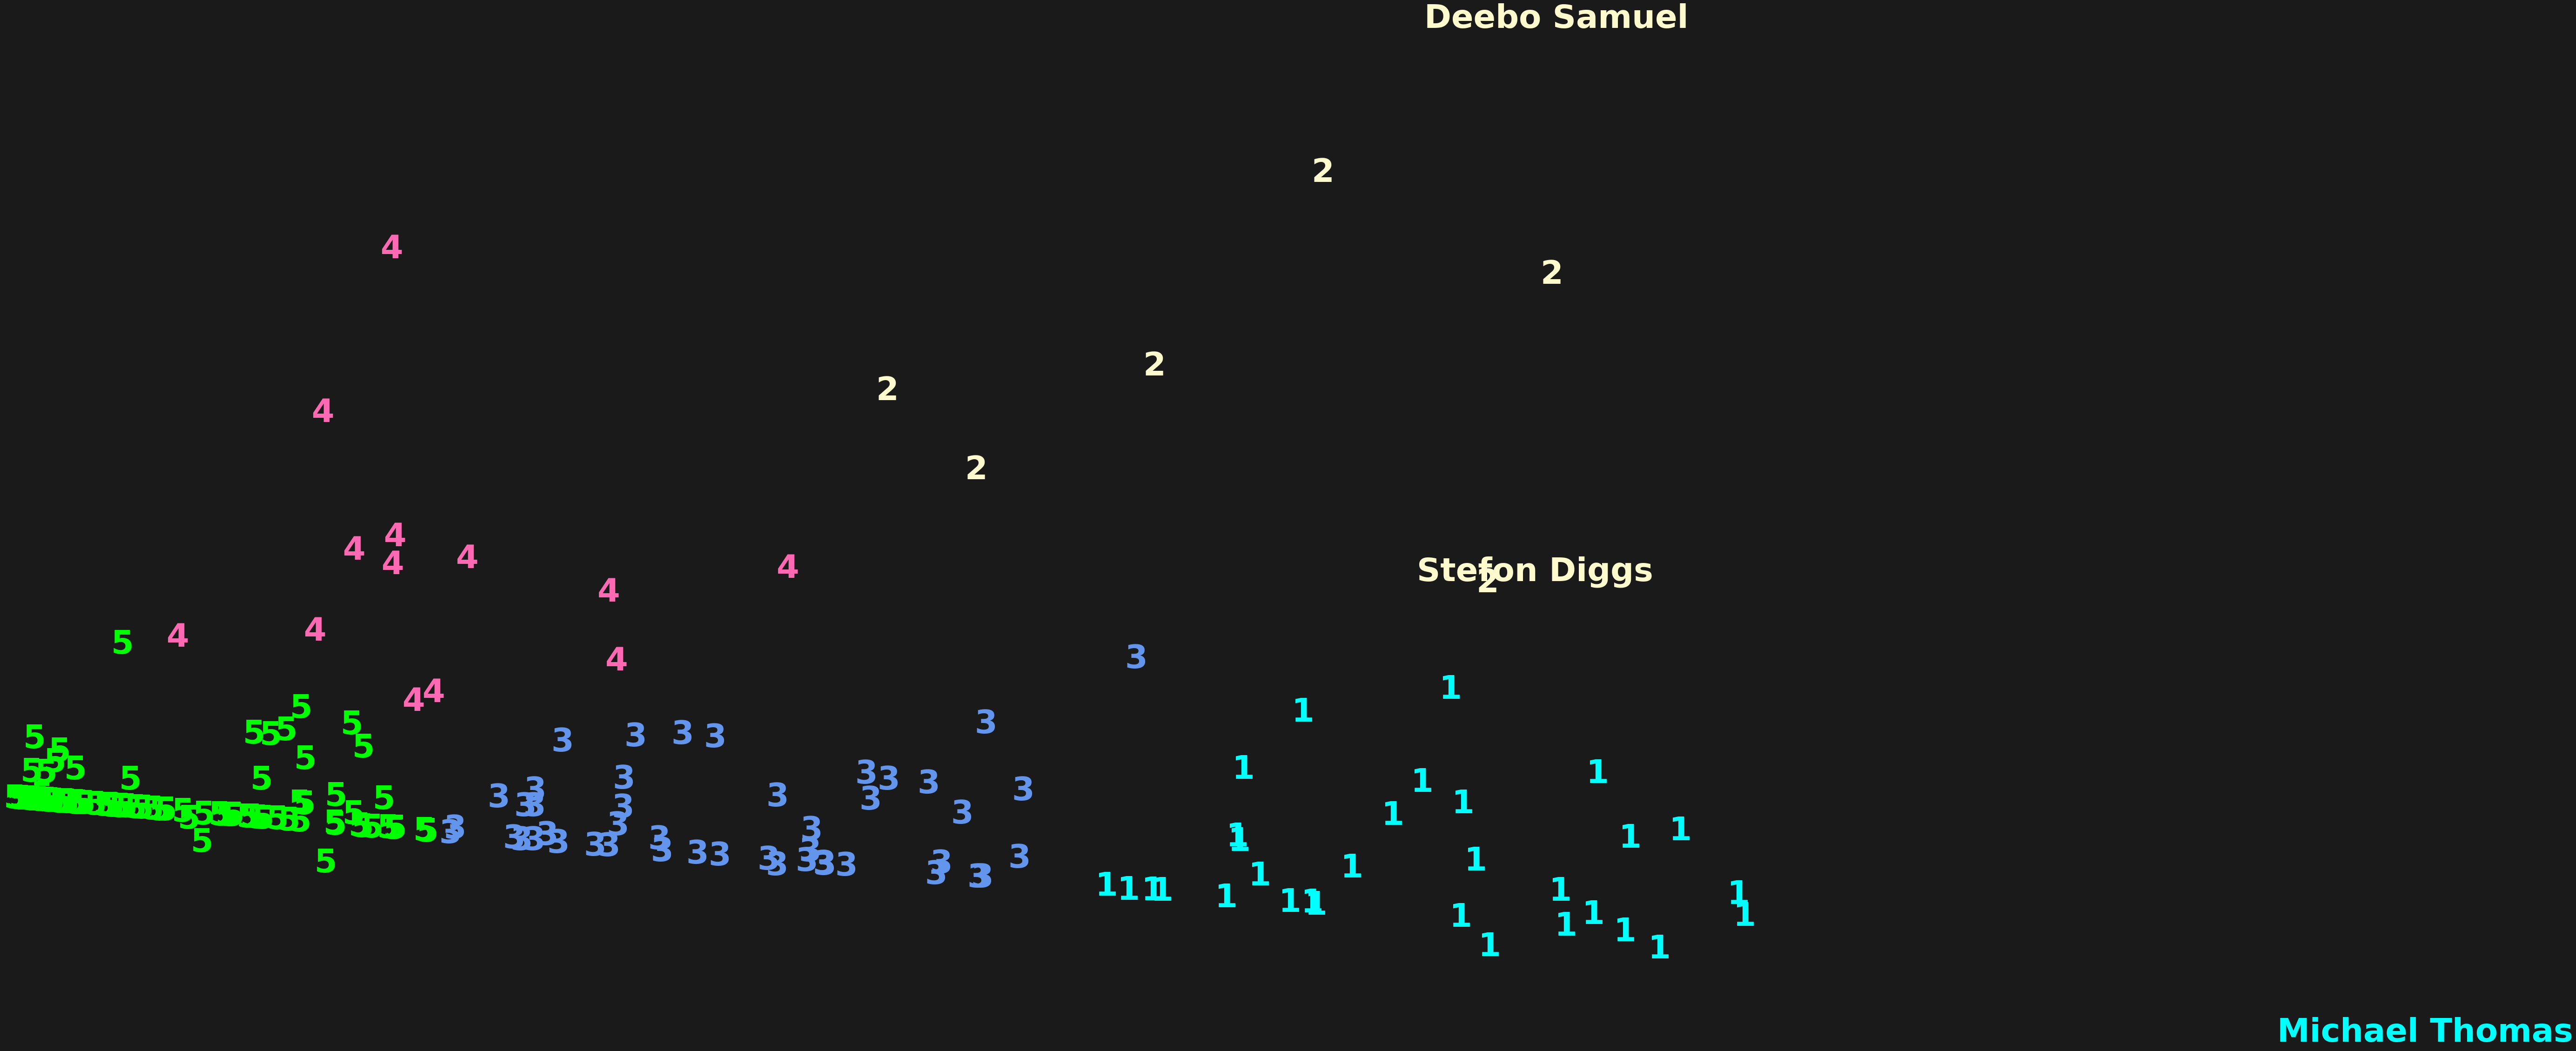

In [1329]:
sns.set(rc={'figure.facecolor':'k'})

pca = PCA(n_components=2).fit_transform(wrs_std)
tier_dict = {2:1, 3:2, 0:3, 4:4, 1:5}

plt.figure(figsize=(10,5))
colours = ['cornflowerblue','lime','cyan','lemonchiffon','hotpink']
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(wrs.player[i] if wrs.player[i]=='Stefon Diggs' or wrs.player[i]=='Michael Thomas' or wrs.player[i]== 'Deebo Samuel' else tier_dict[wrs.GROUP[i]]),
             color=colours[wrs.GROUP[i]],
             fontdict={'weight': 'bold', 'size': 70}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

> That's more like it! With the removal of the `fumbles_lost`column, not only did Diggs rise into the second tier from the fourth tier, but we've also eliminated any cluster overlap in the dimensionally reduced space. We'll take a look at how the clusters appear in a t-SNE dimensionally reduced space.

In [1330]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(wrs_std)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 217 samples in 0.000s...
[t-SNE] Computed neighbors for 217 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 217 / 217
[t-SNE] Mean sigma: 0.200895
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.770367
[t-SNE] KL divergence after 300 iterations: 0.203883


In [1331]:
sns.set(rc={'figure.facecolor':'k'})

pca = PCA(n_components=2).fit_transform(wrs_std)
tier_dict = {2:1, 3:2, 0:3, 4:4, 1:5}

plt.figure(figsize=(10,5))
colours = ['cornflowerblue','lime','cyan','lemonchiffon','hotpink']
for i in range(tsne_results.shape[0]):
    plt.text(tsne_results[i, 0], tsne_results[i, 1], str(wrs.player[i] if wrs.player[i]=='Michael Thomas' else tier_dict[wrs.GROUP[i]]),
             color=colours[wrs.GROUP[i]],
             fontdict={'weight': 'bold', 'size': 100}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

> With the clustering taking place on the periphery with Tiers 2 and 4, I wonder if the separation of `rush_yds` and `rec_yds` is creating some counter-classifying dimensionality to our data. Afterall, rushing yards and receving yards score the same amount of points on Draftkings. Since they score the same, we'll combine `rush_yds` and `rec_yds` into `total_yds`, just as we did with the running backs.


In [1332]:
# Combining rush_yds and rec_yds into total_yds.
wrs = nfl_wrs[['rush_yds','receptions','rec_yds','scoring_td','dkpt']]
wrs['total_yds'] = wrs.rush_yds + wrs.rec_yds
wrs = wrs[['receptions','total_yds','scoring_td','dkpt']]
wrs_std = scaler.fit_transform(wrs)

# Re-run the algorithm with 5 clusters and group players
km = KMeans(n_clusters=5, random_state=0)
km.fit(wrs_std)

wrs['GROUP'] = km.labels_
wrs.groupby('GROUP').mean().style.apply(highlight_max)

In [1333]:
# Add a player column to the wrs dataframe again
wrs.loc[:,'player'] = nfl_wrs.loc[:, 'player']

In [1334]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(wrs_std)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 217 samples in 0.000s...
[t-SNE] Computed neighbors for 217 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 217 / 217
[t-SNE] Mean sigma: 0.156113
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.092842
[t-SNE] KL divergence after 300 iterations: 0.155865


In [1335]:
sns.set(rc={'figure.facecolor':'k'})

pca = PCA(n_components=2).fit_transform(wrs_std)
tier_dict = {4:1, 1:2, 2:3, 0:4, 3:5}

plt.figure(figsize=(10,5))
colours = ['cornflowerblue','lime','cyan','hotpink','lemonchiffon']
for i in range(tsne_results.shape[0]):
    plt.text(tsne_results[i, 0], tsne_results[i, 1], str(wrs.player[i] if i==0 else tier_dict[wrs.GROUP[i]]),
             color=colours[wrs.GROUP[i]],
             fontdict={'weight': 'bold', 'size': 100}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

> Finally we're seeing some clear delineations between tiers without any odd peripheral behavior. We now take a final look at which players each tier contains.

In [1336]:
print(f'Tier 1 WRs:\n\n {list(wrs.player.loc[wrs.GROUP == 4])}\n' + '-'*100)
print(f'Tier 2 WRs:\n\n {list(wrs.player.loc[wrs.GROUP == 1])}\n' + '-'*100)
print(f'Tier 3 WRs:\n\n {list(wrs.player.loc[wrs.GROUP == 2])}\n' + '-'*100)
print(f'Tier 4 WRs:\n\n {list(wrs.player.loc[wrs.GROUP == 0])}\n' + '-'*100)
print(f'Tier 5 WRs:\n\n {list(wrs.player.loc[wrs.GROUP == 3])}\n' + '-'*100)

Tier 1 WRs:

 ['Michael Thomas', 'Chris Godwin', 'Kenny Golladay', 'Cooper Kupp', 'Julio Jones', 'DeVante Parker', 'Amari Cooper', 'Mike Evans', 'DeAndre Hopkins', 'Keenan Allen', 'Allen Robinson', 'Julian Edelman', 'Jarvis Landry', 'Tyler Lockett', 'DJ Chark', 'Courtland Sutton', 'Stefon Diggs', 'John Brown', 'Michael Gallup', 'D.J. Moore', 'Robert Woods', 'Tyler Boyd', 'Davante Adams', 'Odell Beckham']
----------------------------------------------------------------------------------------------------
Tier 2 WRs:

 ['A.J. Brown', 'Calvin Ridley', 'Terry McLaurin', 'Deebo Samuel', 'Marvin Jones', 'Tyreek Hill', 'D.K. Metcalf', 'Emmanuel Sanders', 'Darius Slayton', 'Jamison Crowder', 'Cole Beasley', 'Curtis Samuel', 'Robby Anderson', 'Chris Conley', 'Diontae Johnson', 'Golden Tate', 'Larry Fitzgerald', 'Breshad Perriman', 'Tyrell Williams', 'Marquise Brown', 'Mecole Hardman', 'Adam Thielen']
-----------------------------------------------------------------------------------------------

> The final tier structure for wide receivers is finally making sense. Notice how Stefon Diggs climbed all the way into the top tier from Tier 4.
# Conclusion
For the purposes of clustering similar scoring players, not even scaling the values prevented a slightly significant statistic (from a scoring perspective), like `fumbles_lost`, from completely obscuring a top receiver's true ranking. With corrective action taken, I think that these clusters have achieved what was intended. It's also worth pointing out that silhouete scores did not typically determine which how many clusters truly established sensible hierarchies.